## Figure 4. Learning cost gradient (fixed input $x$)

In [1]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

#%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as rand
import pandas as pd
import seaborn as sns
from matplotlib import animation, rc
from IPython.display import HTML

from lib.lif import LIF, ParamsLIF

Populating the interactive namespace from numpy and matplotlib


In [2]:
nsims = 500
B1 = 10
B2 = 30
x = 2
tau_s = 0.020
c = 0.99
N = 20
wmax = 20

learnt_beta = np.load('./sweeps/learningbeta_fixedx_sweepw.npz')
beta_rd = learnt_beta['beta_rd']

fn_in = './sweeps/param_w_N_%d_nsims_%d_c_%f_default_simulations.npz'%(N, nsims, c)
sims = np.load(fn_in)
hs = sims['hs']
vs = sims['vs']
wvals = sims['wvals']

t_filter = np.linspace(0, 0.150, 150)
exp_filter = np.exp(-t_filter/tau_s)
exp_filter = exp_filter/np.sum(exp_filter)
ds = exp_filter[0]

cost2 = np.zeros((N,N))
cost2_tmp = np.zeros((nsims,hs.shape[4]))

B1 = 2
B2 = 7
x = .05
y = 0.15
z = -0.2

In [4]:
#nsims = 10;

In [8]:
#Estimate mean cost function from sims
for i in range(N):
    print("W[0] = %d"%i)
    for j in range(N):
        for k in range(nsims):
            s1 = np.convolve(hs[i,j,k,0,:], exp_filter)[0:hs.shape[4]]
            s2 = np.convolve(hs[i,j,k,1,:], exp_filter)[0:hs.shape[4]]
            #cost2_tmp[k,:] = (B1*s1/4 - 30*x**2)**2 + (B2*s2 - 4*(B1*s1)**2)**2
            cost2_tmp[k,:] = (B1*s1-x)**2 + (z+B2*s2 - B2*(2*B1*s1-y)**2)**2
            #cost2_tmp[k,:] = (B1*s1 + B2*s2 - x**2)**2
        cost2[i,j] = np.mean(cost2_tmp)

W[0] = 0
W[0] = 1
W[0] = 2
W[0] = 3
W[0] = 4
W[0] = 5
W[0] = 6
W[0] = 7
W[0] = 8
W[0] = 9
W[0] = 10
W[0] = 11
W[0] = 12
W[0] = 13
W[0] = 14
W[0] = 15
W[0] = 16
W[0] = 17
W[0] = 18
W[0] = 19


In [33]:
learnt_beta = np.load('./sweeps/learningbeta_fixedx_sweepw_banana.npz')
beta_rd = learnt_beta['beta_rd']
beta_rd_true = learnt_beta['beta_rd_true']
wmax = 20
#print(beta_rd.shape)

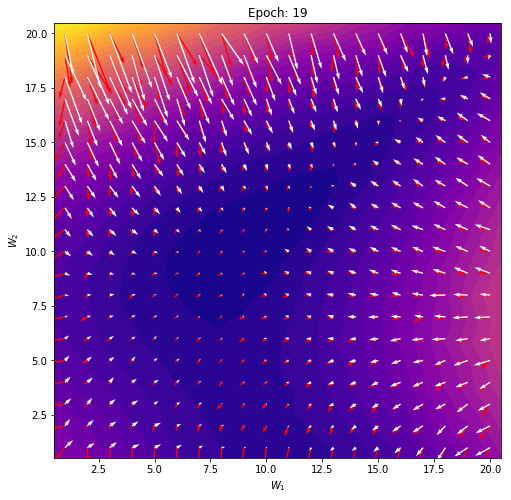

In [34]:
#Plot learning progress over cost function as quiver plots
grad = np.gradient(cost2)
X, Y = np.meshgrid(np.linspace(1,wmax,N), np.linspace(1,wmax,N))
#for ep in range(beta_rd.shape[3]):
ep = 19
fig, ax1 = plt.subplots(1,1,figsize=(8,8))
a=ax1.contourf(np.log(cost2), 30, cmap='plasma', origin='lower', extent=[0, wmax+1, 0, wmax+1])
ax1.quiver(X, Y, -beta_rd[:,:,1,ep], -beta_rd[:,:,0,ep], color=(1, 0, 0))
ax1.quiver(X, Y, -grad[1], -grad[0], color=(1, 1, 1))
ax1.set_title("Regression discontinuity")
ax1.set_xlabel('$W_1$')
ax1.set_ylabel('$W_2$')
ax1.set_title('Epoch: %d'%ep)
#fig.colorbar(a);


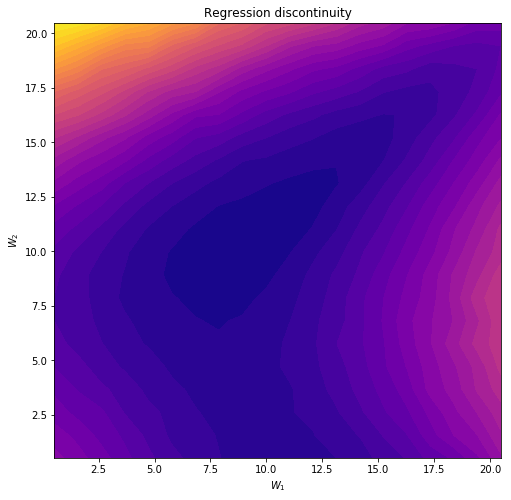

In [37]:
fig, ax1 = plt.subplots(1,1,figsize=(8,8))
grad = np.gradient(cost2)
X, Y = np.meshgrid(np.linspace(1,wmax,N), np.linspace(1,wmax,N))

def init():
    a=ax1.contourf(np.log(cost2), 30, cmap='plasma', origin='lower', extent=[0, wmax+1, 0, wmax+1])
    ax1.set_title("Regression discontinuity")
    ax1.set_xlabel('$W_1$')
    ax1.set_ylabel('$W_2$')
    #fig.colorbar(a);
    return (a,)

def animate(ep):
    a=ax1.contourf(np.log(cost2), 30, cmap='plasma', origin='lower', extent=[0, wmax+1, 0, wmax+1])
    ax1.quiver(X, Y, -beta_rd[:,:,1,ep], -beta_rd[:,:,0,ep], color=(1, 0, 0))
    ax1.quiver(X, Y, -grad[1], -grad[0], color=(1, 1, 1))
    ax1.set_title('Epoch: %d'%ep)
    return (None,)        

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=40, interval=500, blit=False)

In [38]:
rc('animation', html='html5')
matplotlib.rcParams['animation.writer'] = 'avconv'
HTML(anim.to_html5_video())

Make error as a function of epoch

In [39]:
errors_rd = np.zeros((N,N,beta_rd.shape[3]))
for ep in range(beta_rd.shape[3]):
    norm = np.sqrt(grad[0]**2 + grad[1]**2)
    errors_rd[:,:,ep] = np.divide(np.sqrt((beta_rd[:,:,0,ep]-grad[0])**2 + (beta_rd[:,:,1,ep]-grad[1])**2),norm)
errors_rd = errors_rd.reshape((-1,1,beta_rd.shape[3]));

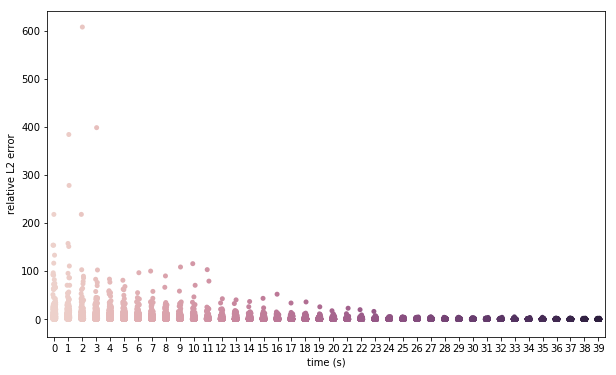

In [46]:
data = pd.DataFrame(errors_rd[:,0,:])
#sns.violinplot(data=data, palette="muted", jitter=True)
ax = sns.stripplot(data=data, palette=sns.cubehelix_palette(40), jitter=True)
ax.set_ylabel("relative L2 error")
ax.set_xlabel('time (s)');

Compare to BP estimate, not the numerical cost gradient:

In [41]:
errors_rd = np.zeros((N,N,beta_rd.shape[3]))
for ep in range(beta_rd.shape[3]):
    norm = np.sqrt(beta_rd_true[:,:,0,ep]**2 + beta_rd_true[:,:,1,ep]**2)
    errors_rd[:,:,ep] = np.divide(np.sqrt((beta_rd[:,:,0,ep]-beta_rd_true[:,:,0,ep])**2 + (beta_rd[:,:,1,ep]-beta_rd_true[:,:,1,ep])**2),norm)
errors_rd = errors_rd.reshape((-1,1,beta_rd.shape[3]));

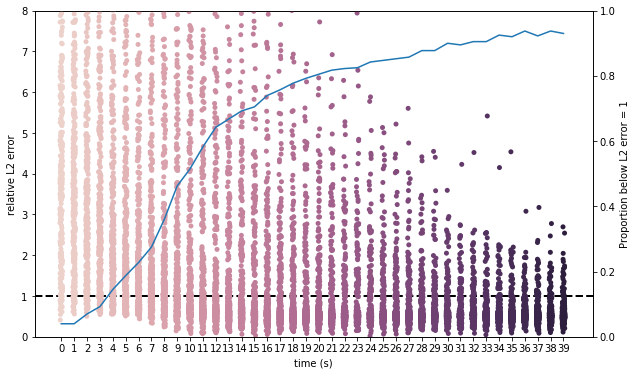

In [65]:
data = pd.DataFrame(errors_rd[:,0,:])
#sns.violinplot(data=data, palette="muted", jitter=True)
#ax = sns.swarmplot(data=data, palette=sns.cubehelix_palette(20))
ax = sns.stripplot(data=data, palette=sns.cubehelix_palette(40), jitter=True)
ax.set_ylabel("relative L2 error")
ax.set_xlabel('time (s)');
ax.set_ylim([0, 8])
ax.axhline(y=1, linestyle='--', color='k', linewidth=2);
ax1 = ax.twinx()
ax1.plot(range(40), np.sum(errors_rd[:,0,:]<1,0)/400.)
ax1.set_ylim([0, 1])
ax1.set_ylabel('Proportion below L2 error = 1')